<a id='intro'></a>
## 1. Introduction

The goal of this workshop is to use protoDUNE simulated data to reconstruct the invariant mass of the $\pi^0$. This is good calibration source for protoDUNE as the $\pi_0$ mass is well known, $m_{\pi^0} = 134.9766(6)\,$MeV/$c^2$. The $\pi_0$ is a neutral meson that has the following decay modes:

  - $\pi_0\rightarrow\gamma\gamma$ with a ~99% branching ratio;
  - $\pi_0\rightarrow\gamma e^+ e^-$ with a ~1% branching ratio;
  - Other decay modes with a BR of order $10^{-5}$ or less.
  
Here we focus on the first decay mode. The kinematics of this decay are derived in

http://physics.princeton.edu/~mcdonald/examples/piondecay.pdf

and result in the following formula for the invariant mass:

$$m_{\pi^0} = \sqrt{2E_1E_2\left(1-\cos\theta\right)}$$

with
  - $E_1$, $E_2$ the energy carried by each photon;
  - $\theta$ the opening angle between the two photons.
  
The picture below shows an example of a $\pi^0$ produced in a hadronic interaction inside the ICARUS LAr TPC:
  
![pi0_decay](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/64d4bf5bcb1c089e75f8c4ec99d785034e1be8a0/11-Figure5-1.png)

In order to reconstruct the $\pi_0$, one needs to 
1. Identify pion decays;
2. Reconstruct the energy of the two photons;
3. Reconstruct the angle betwen them.

Achieving this goal requires many elements of the ML-based reconstruction chain to work, which makes it a good benchmark to assess its performace. This notebook presents how to run the chain with several different parameters.

<a id='prereq'></a>
## 2. Prerequisites

Here is compiled all you need to know and do before you can get started. If you have already set this up, you may skip to the next chapter.

1. Connect to a SLAC GPU machine, e.g.

```bash
ssh user@hep-gpu01.slac.stanford.edu
```

2. Create your own directory, move to it

```bash
mkdir -p /gpfs/slac/staas/fs1/g/neutrino/user/ipynb
cd /gpfs/slac/staas/fs1/g/neutrino/user/ipynb
```

3. Execute a singularity that contains `python3`, `LArCV2` and all other necessary packages

```bash
singularity exec --bind /scratch/ --bind /gpfs/ --nv /gpfs/slac/staas/fs1/g/neutrino/kterao/images/ub18.04-cuda100-py3-pytorch1.1.0-scn.sif bash
```

4. Download the `lartpc_mlreco3d` (ML-based reconstruction) and `pi0_reco` ($\pi^0$ specific algos) repos

```bash
git clone https://github.com/drinkingkazu/lartpc_mlreco3d/tree/develop
git clone https://github.com/francois-drielsma/pi0_reco
```

4. Copy this notebook to your own directory

```bash
cp /gpfs/slac/staas/fs1/g/neutrino/drielsma/ipynd/Pi0\ Workshop\ Main.ipynb .
```

5. Launch jupyter notebook

```bash
jupyter notebook --no-browser --port=8080
```

6. Forward port to local machine (execute this line on your machine)

```bash
ssh -N -L 8080:localhost:8080 drielsma@nu-gpu01.slac.stanford.edu
```

7. Open in local machine browser

```hmtl
http://localhost:8080/tree
```

<a id='chain'></a>
## 3. Full chain

In this chapter, we run the full $\pi^0$ reconstruction chain, with switches at each step of the chain:

![pi0_decay](https://github.com/DeepLearnPhysics/2019-09-CSUWorkshop/blob/master/drielsma/pi0_flowchart.jpg?raw=true)


1. Choose the input to the chain:
  - `energy` to use true energy deposition information. Using this skips to step 4
  - `charge` to use reconstructed Cluster3D charge
  - **For more details** on the data loader, refer to `Pi0 Workshop Data Loader.ipynb`
2. Remove ghosts and do semantic segmentation (HIP, MIP, shower, delta, Michel) by either:
  - True segmentation (`mask`)
  - Loading the specified trained weights and using UResNet (`uresnet`)
  - **For more details** on the procedure, refer to `Pi0 Workshop UResNet.ipynb`
3. Reconstruct energy in each voxel by either:
  - Applying a constant conversion factor from charge to energy (`constant`)
  - Correcting from lifetime, recombination, spacecharge (`full`)
  - Using a UResNet that predicts energy, i.e. ENet (`enet`, not implemented)
  - **For more details** on the procedure, refer to `Pi0 Detector Response.ipynb`
4. Identify shower starts by either:
  - Using true starting points (`truth`)
  - Loading the specified trained weights and using PPN (`ppn`)
  - **For more details** on the procedure, refer to `Pi0 Workshop PPN.ipynb`
5. Reconstruct shower directions by either (this provides directions):
  - Using Geant4 true momentum (`truth`)
  - Using PCA (`pca`)
  - Using centroid (`cent`)
  - **For more details** on the procedure, refer to `Pi0 Workshop Cone Clustering.ipynb`
6. Cluster individual showers by either (this provides energies):
  - Use Geant4 true energy (`truth`)
  - Using group labels (`group`)
  - Using cone clustering (`cone`)
  - Loading the specified trained weights and using GNN (`gnn`)
  - **For more details** on the procedure, refer to `Pi0 Workshop Clustering.ipynb`
7. Identify decays by either:
  - Using Geant4 production information (`truth`)
  - Matching showers using shower directions (`proximity`)
  - **For more details** on the procedure, refer to `Pi0 Workshop Pi0 Identification.ipynb`
8. Assemble energies and angle to get $\pi^0$ mass

Below is the configuration of the data loader:

In [1]:
import sys
sys.path.append("../lartpc_mlreco3d")
sys.path.append("../pi0_reco")

import yaml

# Configuration for the data loader
io_cfg =  """
iotool:
  batch_size: 1 
  #minibatch_size: 5 
  shuffle: False
  num_workers: 4
  collate_fn: CollateSparse
  #sampler:
  #  name: RandomSequenceSampler 
  #  batch_size: 32
  dataset:
    name: LArCVDataset 
    data_keys:
    #- /gpfs/slac/staas/fs1/g/neutrino/kvtsang/pdune/mpv/val/*.root
    #- /gpfs/slac/staas/fs1/g/neutrino/kvtsang/data/2019-09-27/*.root
    - /gpfs/slac/staas/fs1/g/neutrino/kvtsang/data/2019-09-27/larcv_mc_00001.root
    limit_num_files: 5
    schema:
      input_data: 
        - parse_sparse3d_scn
        - sparse3d_reco
        - sparse3d_reco_inv_chi2
        - sparse3d_reco_hit_charge0
        - sparse3d_reco_hit_charge1
        - sparse3d_reco_hit_charge2
        - sparse3d_reco_hit_rms0
        - sparse3d_reco_hit_rms1
        - sparse3d_reco_hit_rms2
        - sparse3d_reco_hit_time0
        - sparse3d_reco_hit_time1
        - sparse3d_reco_hit_time2                                                                        
        - sparse3d_reco_occupancy
      energy:
        - parse_sparse3d_scn
        - sparse3d_mcst
      charge:
        - parse_sparse3d_scn
        - sparse3d_reco
      segment_label_true:
        - parse_sparse3d_scn
        - sparse3d_fivetypes_true
      segment_label_reco:
        - parse_sparse3d_scn
        - sparse3d_fivetypes_reco
      particles:
        - parse_particle_asis
        - particle_mcst
        - cluster3d_mcst
      particles_label:
        - parse_particle_points
        - sparse3d_reco                                                                                  
        - particle_mcst
      group_label_true:
        - parse_cluster3d_clean
        - cluster3d_mcst
        - sparse3d_mcst
      group_label_reco:
        - parse_cluster3d
        - cluster3d_mcst_reco
        - sparse3d_mcst
      dbscan_label_true:
        - parse_dbscan
        - sparse3d_fivetypes_true
      dbscan_label_reco:
        - parse_dbscan
        - sparse3d_fivetypes_reco
"""

The configuration of the chain can be modified easily below:

In [2]:
# Configuration of the reconstruction chain
chain_cfg = '''
name: pi0_chain_test
net_cfg: uresnet_ppn.cfg
input: energy # charge
segment: uresnet # mask, uresnet
response: average # constant, average(, full, enet)
response_cst: 0.0082 # energy response constant (0.0082 for mask, 0.0052 for uresnet)
response_average: 0.877 # energy response average (1.3693 for mask, 0.877 for uresnet)
shower_start: truth # truth, ppn
shower_dir: truth # truth, pca, cent
shower_energy: truth # truth, group, cone, gnn
shower_match: truth # truth, proximity
refit_dir: true # true, false
refit_cone: true # true, false
'''
chain_cfg = yaml.load(chain_cfg,Loader=yaml.Loader)

This configuration specifies which route to take in the chain from data to $\pi^0$ mass. Also adds:
  - Name of the chain, it will determine the path to a log file that stores results
  - When a network is requested for a step, give path to the architecture configuration file
  - When a constant or average energy reponse factor is used, give it
  - Request to refit the the photon direction using the vertex information from the shower matching
  - Request to refit cones using the refit directions

The chain is implemented in `chain.py` in the `pi0_reco` repository and can be called as follows:

In [3]:
from IPython.display import HTML, display

# Decorative progress bar
def progress(count, total, unit, message=''):
    return HTML("""
        <progress 
            value='{count}'
            max='{total}',
            style='width: 30%'
        >
            {count}
        </progress> {count}/{total} {unit} ({frac}%) ... {message}
    """.format(count=count, total=total, unit=unit, frac=int(float(count)/float(total)*100.),message=message))

In [4]:
# Initialize the chain
from pi0.chain import Pi0Chain
chain = Pi0Chain(io_cfg, chain_cfg)
from larcv import larcv

# Loop over the full dataset
masses = []
i_draw, n_draw = 0, 1
data_size = len(chain.hs.data_io)
out = display(progress(0,data_size,'images'),display_id=True)

for i in range(data_size):

    # Compute masses, log them
    chain.run_loop()
    
    # Draw the last event if requested
    if 'matches' in chain.output and len(chain.output['matches']) and i_draw < n_draw:
        chain.draw(draw_input=True)
        i_draw += 1

    out.update(progress(i,data_size,'images'))
out.update(progress(data_size,data_size,'images'))
        
# Simplest way to run the full chain
#chain = Pi0Chain(io_cfg, chain_cfg)
#chain.run()

Initialized Pi0 mass chain, log path: pi0_chain_test_log.csv

Config processed at: Linux nu-gpu01.slac.stanford.edu 3.10.0-1062.9.1.el7.x86_64 #1 SMP Fri Dec 6 15:49:49 UTC 2019 x86_64 x86_64 x86_64 GNU/Linux

$CUDA_VISIBLE_DEVICES=""

{   'iotool': {   'batch_size': 1,
                  'collate_fn': 'CollateSparse',
                  'dataset': {   'data_keys': [   '/gpfs/slac/staas/fs1/g/neutrino/kvtsang/data/2019-09-27/larcv_mc_00001.root'],
                                 'limit_num_files': 5,
                                 'name': 'LArCVDataset',
                                 'schema': {   'charge': [   'parse_sparse3d_scn',
                                                             'sparse3d_reco'],
                                               'dbscan_label_reco': [   'parse_dbscan',
                                                                        'sparse3d_fivetypes_reco'],
                                               'dbscan_label_true': [   'parse_dbscan',


<Figure size 1080x720 with 0 Axes>

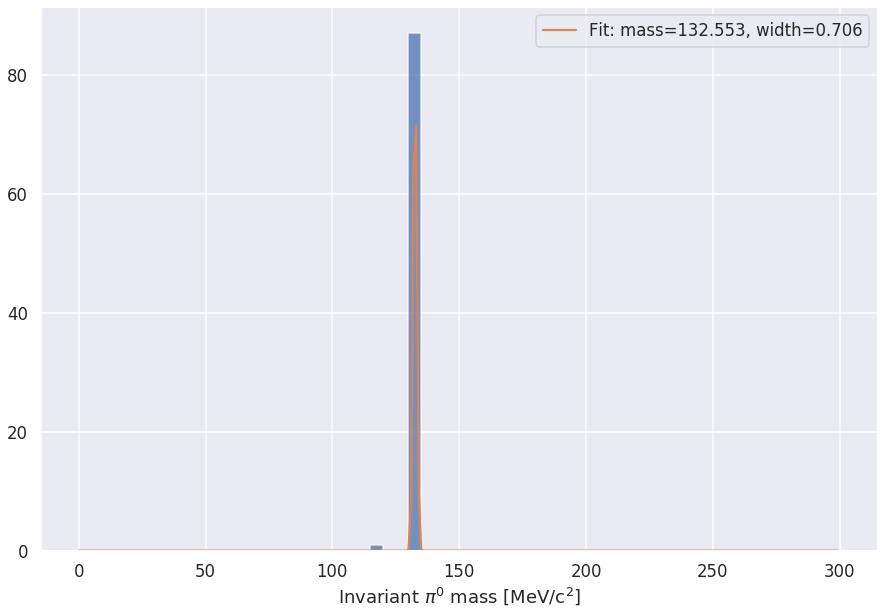

,event_id,pion_id,pion_mass
35,45.0,0.0,134.976600
36,46.0,0.0,134.976600
37,48.0,0.0,134.976600
38,51.0,0.0,134.976600
39,51.0,1.0,117.075372
40,52.0,0.0,134.976600
41,53.0,0.0,134.976600
42,54.0,0.0,134.976600
43,55.0,0.0,134.976600
44,57.0,0.0,134.976600


In [6]:
import numpy as np
import pandas as pd
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk') # or paper

def gaus(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/2./sigma**2)/np.sqrt(2)/np.pi/sigma

def fit_func(bins, n, func):
    from scipy.optimize import curve_fit
    center = (bins[:-1] + bins[1:]) / 2
    popt, pcov = curve_fit(func, center, n, p0=(100, 100, 10))

    x = np.arange(0, 300, 1)
    y = func(x, popt[0], popt[1], popt[2])
    plt.plot(x, y, label='Fit: mass=%5.3f, width=%5.3f' % (popt[1], popt[2]))
    plt.legend()

# Load the output file, draw mass peak
df = pd.read_csv(chain_cfg['name']+'_log.csv')
plt.figure()
fig, ax = plt.subplots()
n, bins, patches = ax.hist(df.pion_mass, bins=60, range=[0,300], alpha=0.75)
ax.set_xlabel('Invariant $\pi^0$ mass [MeV/c$^2$]')

# Fit the peak with a Gaussian
fit_func(bins, n, gaus)
plt.show()

# Print pion mass dataframe
df[35:45]
#print(df.to_string())